# Loading the dataset 

In [40]:
import polars as pl
import openai
import numpy as np
import json
from dotenv import dotenv_values

config = dotenv_values(".env")
key = config['THE_KEY']

client = openai.AzureOpenAI(
    azure_endpoint=config['ENDPOINT'],
    api_key=key,
    api_version="2023-05-15"
)

## Recovering the annotation shuffle order and the ground-truth labels

## Generating predictions with GPT-4

In [12]:
import pandas as pd
# path = "Sentence Shuffling/shuffled_sent_data.jsonl"
sentence_json = "Sentence Shuffling/sentencedataset.json" # this is the original json file

# sentence json is a json line file
# read the json file
df = pd.read_json(sentence_json, lines=True)
df_pl = pl.from_pandas(df)
df_pl = df_pl.group_by(["paragraph_id", "story_id", "source", "URL", "title"]).agg(
    pl.col('sentence'), pl.col('sentence_id') 
)
# 

In [89]:
df_pl.filter(pl.col('Source'))

paragraph_id,story_id,source,URL,title,sentence,sentence_id,num_sents,shuffled_indices
i64,i64,str,str,str,list[str],list[i64],u32,list[i64]
16,16,"""ChiSCor""","""https://osf.io…","""035401""","[""once upon the time there was this cowboy and he had a farm on the border between America and Mexico."", ""he helped the police chief in the place called Arizona."", … ""the end.""]","[359, 360, … 376]",18,"[0, 1, … 6]"
17,17,"""ChiSCor""","""https://osf.io…","""135401""","[""once upon a time there lived a little girl called Wednesday."", ""she lived in a big house in a dark forest where it was always misty."", … ""the end.""]","[377, 378, … 390]",14,"[10, 2, … 4]"
29,29,"""ChiSCor""","""https://osf.io…","""085402""","[""there used to be a fairy who's name was Maleficent."", ""she used to fight wars in the mosque which is her home."", … ""the end.""]","[545, 546, … 560]",16,"[1, 13, … 10]"
51,51,"""ChiSCor""","""https://osf.io…","""045401""","[""once upon a time there was a boy called Andrew and it was his first day of school."", ""he was short and people used to make fun of him."", … ""the end.""]","[805, 806, … 813]",9,"[4, 2, … 8]"
59,59,"""ChiSCor""","""https://osf.io…","""055701""","[""I'm gonna tell about a boy called Kin."", ""he lived in Japan and his father was a ninja and Kin wanted to become also a ninja."", … ""and that is the end of the story.""]","[916, 917, … 941]",26,"[15, 16, … 25]"
61,61,"""ChiSCor""","""https://osf.io…","""065402""","[""once upon a time there lived a family with a daughter a mother and a father."", ""the daughter was very spoiled by her parents."", … ""and they lived happily ever after.""]","[954, 955, … 964]",11,"[4, 2, … 1]"
73,66,"""The Aesop for …","""https://www.gu…","""Hercules and t…","[""The farmer climbed down from his seat and stood beside the wagon looking at it but without making the least effort to get it out of the rut."", ""All he did was to curse his bad luck and call loudly on Hercules to come to his aid."", ""Then, it is said, Hercules really did appear, saying:""]","[1046, 1047, 1048]",3,"[2, 1, 0]"
94,69,"""The Aesop for …","""https://www.gu…","""The Wolf and t…","[""""What!"", ""A chain!"""", … """"Don't you go wherever you please?""""]","[1094, 1095, … 1097]",4,"[2, 3, … 0]"
98,70,"""The Aesop for …","""https://www.gu…","""The Wolf and h…","[""""Why,"" exclaimed the Wolf proudly, ""see how big I am!"", ""Fancy me running away from a puny Lion!"", ""I'll show him who is fit to be king, he or I.""""]","[1106, 1107, 1108]",3,"[2, 1, 0]"


In [57]:
np.random.seed(42)

def get_shuffled_sentences(row):
    print(row)
    # shuffled_indices = row['shuffled_indices']
    # sentence = row['sentence']
    # return [sentence[i] for i in shuffled_indices]
df_pl = df_pl.with_columns(
    pl.col('sentence_id').list.lengths().alias('num_sents')
).with_columns(
    # create a new column that is a shuffled list from 0 to num_sents
    pl.col('num_sents').map_elements(
        lambda s: np.random.choice(s, s, replace=False).tolist() 
    ).alias('shuffled_indices')
)

In [52]:
df_pl.columns

['paragraph_id',
 'story_id',
 'source',
 'URL',
 'title',
 'sentence',
 'sentence_id',
 'num_sents',
 'shuffled_indices']

## Dataset statistics

### ChisCor

NUmber of stories: 65


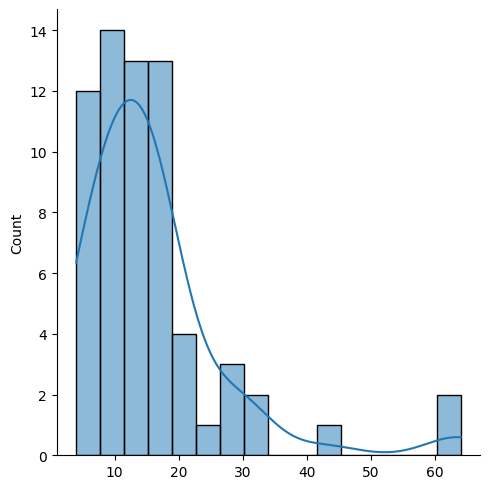

In [24]:
import seaborn as sns
# number of stories:
num_stories = len(df_pl.filter(pl.col('source')=='ChiSCor')['story_id'].unique())
print(f"NUmber of stories: {num_stories}")
# distribution of number of sentences per datapoint in chiscor

num_sents_series = df_pl.filter(pl.col('source')=='ChiSCor').with_columns(pl.col('sentence').list.lengths().alias('num_sentences'))['num_sentences']
sns.displot(num_sents_series, kde=True)

In [28]:
# what's up with the 60+ sentence story?
df_pl.filter(pl.col('source')=='ChiSCor').filter(pl.col('sentence').list.lengths() > 60)['sentence'][0].to_list()

["I'm going to continue the story.",
 'so then uncle Vernon had planned that they were going to get a new house which was far in the sea.',
 'so then they went to the house.',
 'and then Harry was asleep.',
 'but then the day that were there.',
 "so then it was almost midnight and then at midnight it was Harry's birthday now.",
 'and then Harry was eleven.',
 'but no hold on.',
 'so then it was almost midnight one minute and it and it was his birthday.',
 'so then he drew a cake in the dust.',
 'and then three two one it was his.',
 'then there was a loud crash.',
 'and then the door went went fell to the floor off its off its hinges.',
 'then some kind of big shadowy figure which was ginormous stepped into the room.',
 'and suddenly he said sorry about that and he closed the door.',
 'and then Harry saw that there was a ginormous man right in front of him.',
 'and then Harry said who are you?',
 "and then Hagrid said oh yeah I haven't introduced myself I am Hagrid Hagrid.",
 'I forgot

In [84]:
from tqdm import tqdm
import loguru
from typing import List

logger = loguru.logger
def predict_order(sorted_sents: List[str], shuffled_inds: List[int], predict_sents_and_labels: bool = False):
    if not predict_sents_and_labels:
        prompt = "Please arrange the following shuffled sentences in the correct order in the form of a list of integers that can be read by a python interpreter (e.g., [1,4,3,2]).\n\n"
    else: # predict the sentences and the labels
        prompt = "Please arrange the following shuffled sentences in the correct order in the form of an enumerated list (e.g., 4. {sentence 4} 1. {sentence 1}, ...).\n\n" 
    enumerated_sents = "\n".join([f"{i}. {sorted_sents[ind]}" for i, ind in enumerate(shuffled_inds)])
    prompt_and_sents = prompt + enumerated_sents
    message = [{"role": "user", "content": prompt_and_sents}]
    response = client.chat.completions.create(
            model="gpt4v",
            temperature=0,
            max_tokens = (100 if not predict_sents_and_labels else len(enumerated_sents)),
            messages = message).choices[0].message.content
    if not predict_sents_and_labels:
        return eval(response) # List[int]
    else:
        # have to parse.
        # split by newline
        response = response.split("\n")
        # then take the number at the beginning of each line
        numbers = [int(line.split(".")[0]) for line in response]
        return numbers
# test
# predicted_labels = predict_order(df_pl['sentence'][0].to_list())
num_passed_filter = 0
for i in tqdm(range(len(df_pl))):
    try:
        predicted_labels = predict_order(df_pl['sentence'][i].to_list(), df_pl['shuffled_indices'][i].to_list(), predict_sents_and_labels=True)
    except openai.BadRequestError as e: # Sometimes doesn't make it through the content filter
        logger.error("Content filter was triggered. Skipping this one.")
logger.info(f"Proportion of stories that passed the content filter: {(num_passed_filter)/len(df_pl):.3f}")

# rrrrrrrrr = df_pl['sentence'][0].to_list()
# shuffled_indices = df_pl['shuffled_indices'][0].to_list()
# response = predict_order(sentences, shuffled_indices)
# print(response)
# print(sentences)
# print(shuffled_indices)

  0%|          | 2/1379 [03:03<35:04:48, 91.71s/it]


KeyboardInterrupt: 

In [83]:
df_pl[3]['shuffled_indices'].to_list()

[[4, 2, 7, 5, 0, 3, 1, 6, 8]]

In [72]:
df_pl['sentence'][1].to_list()

['once upon a time there lived a little girl called Wednesday.',
 'she lived in a big house in a dark forest where it was always misty.',
 'they lived in a on a hill.',
 'and down in the hill there was a bright called Roabloxean.',
 'they never left the house.',
 'and one day the a plant got both of them out of their bed.',
 'Wednesday said now may you please put me down and it did.',
 'she went to breakfast down.',
 'her mother said dust the floor think wake up the kids.',
 'and they were already down.',
 'she was surprised.',
 'and they knew why.',
 'they ate breakfast.',
 'the end.']